# 1D RBF interpolation

https://www.youtube.com/watch?v=Kl9xk9BukNE&t=37s


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
xk = np.linspace(0,1,5)
x = np.linspace(0,1,1000)

def true_fn(x): return x**2-x-np.cos(np.pi*x)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(xk,true_fn(xk),'x', markersize=15)
plt.plot(x, true_fn(x), '--r')
plt.show()

In [ ]:
# make it square
sq_diff = xk.reshape(-1,1) - xk.reshape(1,-1) # numpy broadcasting
dist = np.sqrt(sq_diff**2)

In [ ]:
def euclidean_distance(x, xk):
    return np.sqrt((x.reshape(-1,1) - xk.reshape(1,-1))**2)

In [ ]:
euclidean_distance(xk, xk)

In [ ]:
def gauss_rbf(radius, eps):
    return np.exp(-(eps*radius)**2)

In [ ]:
gauss_rbf(euclidean_distance(xk,xk),2)

In [ ]:
class RBFInterp(object):
    def __init__(self, eps):
        self.eps = eps
        
    def fit(self, xk, yk):
        self.xk_ = xk
        transformation = gauss_rbf(euclidean_distance(xk,xk),self.eps)
        self.w_ = np.linalg.solve(transformation, yk)
    
    def __call__(self, xn):
        transformation = gauss_rbf(euclidean_distance(xn,xk),self.eps)
        return transformation.dot(self.w_)

In [ ]:
model = RBFInterp(2)

yk = true_fn(xk)
model.fit(xk, yk)
print(model.w_)

In [ ]:
model(x)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(xk,true_fn(xk),'x', markersize=15)
plt.plot(x, true_fn(x), '--r')
plt.plot(x, model(x))
plt.show()

# 2D Interpolation

In [ ]:
def func(x1, x2):
    return (x1**2)*np.cos(2*np.pi*x2)

In [ ]:
def generate_data():
    x1 = np.linspace(0,1,10)
    x2 = np.linspace(0,1,10)
    xx, xy = np.meshgrid(x1, x2)
    y = func(xx, xy)
    return np.concatenate([xx.reshape(-1,1),xy.reshape(-1,1)],axis=1), y.reshape(-1,1)

X, y = generate_data()

In [ ]:
def plot_real_func(func, resolution=100):
    x1 = np.linspace(0,1,resolution)
    x2 = np.linspace(0,1,resolution)
    xx, xy = np.meshgrid(x1, x2)
    y = func(xx, xy)
    cs = plt.contour(xx,xy,y)
    plt.clabel(cs)

plt.figure(figsize=(12,6))
plot_real_func(func)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [ ]:
class RBFInterp(object):
    def __init__(self, eps):
        self.eps = eps
        
    def euclidean_distance(self, x, xk):
        x = x[None,...].swapaxes(0,2)
        xk = xk.T[None,...].swapaxes(0,1)
        return np.sqrt(((x-xk)**2).sum(axis=0))
        
    def fit(self,xt, yt):
        self.xk_ = xt
        transformation = self.gauss_rbf(self.euclidean_distance(xt, self.xk_))
        self.w_ = np.linalg.solve(transformation, yt)
        
    def gauss_rbf(self, radius): 
        return np.exp(-1.*(self.eps*radius)**2)
    
    def __call__(self, x):
        transformation = gauss_rbf(euclidean_distance(x,self.xk_),self.eps)
        return transformation.dot(self.w_)
    
    
print(X.shape, y.shape)
    
model = RBFInterp(2)
model.fit(X,y)

x1 = np.linspace(0,1,10)
x2 = np.linspace(0,1,10)
xx, xy = np.meshgrid(x1, x2)
X = np.concatenate([xx.reshape(-1,1),xy.reshape(-1,1)],axis=1)
y = model(X)


def plot_interp(func, resolution=100):
    x1 = np.linspace(0,1,resolution)
    x2 = np.linspace(0,1,resolution)
    xx, xy = np.meshgrid(x1, x2)
    X = np.concatenate([xx.reshape(-1,1), xy.reshape(-1,1)], axis=1)
    y = func(X)
    cs = plt.contour(xx,xy,y.reshape(resolution,resolution))
    plt.clabel(cs)
    
plot_interp(model)
plt.imshow(model(X).reshape(10,10), extent=[0,1,0,1])

https://bitbucket.org/colinmcnally/rbfmhd/src/master/

In [ ]:
import pathlib
import numpy as np
from turboflow.datasets.turb2D import Turb2D
import matplotlib.pyplot as plt

In [ ]:
data_dir = pathlib.Path('/','home','dicarlo_d','Documents','Datasets','2021-Turb2D')
turb2D = Turb2D(data_dir)
turb2D.setup()
turb2D.load_data(42)

In [ ]:
def generate_data(ds):
    xy = turb2D.xy
    uv = turb2D.uv
    
    xy = xy[::ds, ::ds, :].reshape(-1,2)
    uv = uv[::ds, ::ds, :].reshape(-1,2)
    
    return xy, uv

Xtrain, ytrain = generate_data(ds=4)
print(Xtrain.shape)
print(ytrain.shape)

Xtest, ytest = generate_data(ds=1)
print(Xtest.shape)
print(ytest.shape)

In [ ]:
plt.figure(figsize=(10,10))
plt.streamplot(Xtrain[:,0].reshape(64,64)[:,0],
               Xtrain[:,1].reshape(64,64)[0,:],
               ytrain[:,0].reshape(64,64),
               ytrain[:,1].reshape(64,64),
               density=2)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.streamplot(Xtest[:,0].reshape(256,256)[:,0],
               Xtest[:,1].reshape(256,256)[0,:],
               ytest[:,0].reshape(256,256),
               ytest[:,1].reshape(256,256),
               density=2)
plt.show()

In [ ]:
from turboflow.models.kernels import RBFInterp

model = RBFInterp(50000)
model.fit(Xtrain, ytrain)

ypred = model(Xtrain)
plt.imshow(ypred[:,0].reshape(64,64))
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.streamplot(Xtrain[:,0].reshape(64,64)[:,0],
               Xtrain[:,1].reshape(64,64)[0,:],
               ypred[:,0].reshape(64,64),
               ypred[:,1].reshape(64,64),
               density=2)
plt.show()

# DIV-FREE Kernel

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import numpy as np
from turboflow.datasets.turb2D import Turb2D
import matplotlib.pyplot as plt

In [3]:
data_dir = pathlib.Path('/','home','dicarlo_d','Documents','Datasets','2021-Turb2D')
turb2D = Turb2D(data_dir)
turb2D.setup()
turb2D.load_data(42)
#

{'t': 0.42,
 'xy': array([[[0.        , 0.        ],
         [0.        , 0.00392157],
         [0.        , 0.00784314],
         ...,
         [0.        , 0.99215686],
         [0.        , 0.99607843],
         [0.        , 1.        ]],
 
        [[0.00392157, 0.        ],
         [0.00392157, 0.00392157],
         [0.00392157, 0.00784314],
         ...,
         [0.00392157, 0.99215686],
         [0.00392157, 0.99607843],
         [0.00392157, 1.        ]],
 
        [[0.00784314, 0.        ],
         [0.00784314, 0.00392157],
         [0.00784314, 0.00784314],
         ...,
         [0.00784314, 0.99215686],
         [0.00784314, 0.99607843],
         [0.00784314, 1.        ]],
 
        ...,
 
        [[0.99215686, 0.        ],
         [0.99215686, 0.00392157],
         [0.99215686, 0.00784314],
         ...,
         [0.99215686, 0.99215686],
         [0.99215686, 0.99607843],
         [0.99215686, 1.        ]],
 
        [[0.99607843, 0.        ],
         [0.99607843, 0.

In [4]:
def generate_data(ds):
    xy = turb2D.xy
    uv = turb2D.uv
    
    xy = xy[::ds, ::ds, :].reshape(-1,2)
    uv = uv[::ds, ::ds, :].reshape(-1,2)
    
    return xy, uv

Xtrain, ytrain = generate_data(ds=4)
print(Xtrain.shape)
print(ytrain.shape)

Xtest, ytest = generate_data(ds=1)
print(Xtest.shape)
print(ytest.shape)

(4096, 2)
(4096, 2)
(65536, 2)
(65536, 2)


In [5]:
problem_size = 3
res = 256//problem_size
Xtrain, ytrain = generate_data(ds=res)
ytrain = ytrain - ytrain.mean()

L = int(np.sqrt(ytrain.shape[0]))
Xtest, ytest = generate_data(ds=res)
H = int(np.sqrt(ytest.shape[0]))
print(L, H)

4 4


In [6]:
from turboflow.models.kernels import DivFreeRBFInterp

model = DivFreeRBFInterp(0.1)
model.fit(Xtrain, ytrain)
ypred = model(Xtrain)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(ytrain[:,0].reshape(L,L))
plt.subplot(222)
plt.imshow(ypred[:,0].reshape(L,L))
plt.subplot(223)
plt.imshow(ytrain[:,1].reshape(L,L))
plt.subplot(224)
plt.imshow(ypred[:,1].reshape(L,L))
plt.show()

print(model.Xk_.shape)
print(model.w_.shape)
print(model.A_.shape)

plt.figure(figsize=(10,10))
plt.imshow(model.A_)
plt.show()

ypred = model(Xtest)
H = int(ypred.shape[0]**0.5)
print(ypred.shape)

LinAlgError: Matrix is singular.

In [ ]:
ypred = model(Xtest)

https://github.com/sebastianmenze/Vector-interpolation

(100, 100)
(100, 100)


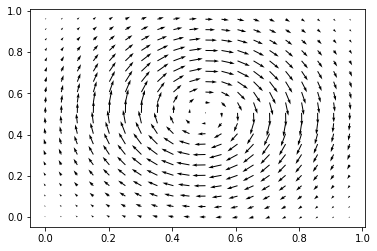

In [109]:
# Generate synthetic eddy data
# following Vennell and beatson JGR 2009
# Eddy field
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

[xx,yy] = np.meshgrid(x,y)

x0 = 0.5
y0 = 0.5

r  = np.sqrt((xx-x0)**2 + (yy-y0)**2)
r0 = 0.25

# a gaussian stream function
g1 = -(2.*((xx-x0)/x0)**2)
g2 = -(2.*((yy-y0)/y0)**2)
G = (x0**2 + y0**2)*np.exp(g1 + g2)

[Gy,Gx] = np.gradient(G,y,x)

# Eddy velocity components
u = -Gy
v =  Gx

print(u.shape)
print(v.shape)

ds = 5
plt.quiver(xx[::ds,::ds],yy[::ds,::ds],
            u[::ds,::ds], v[::ds,::ds],scale=30)
plt.show()

(7, 7)
(49, 2)


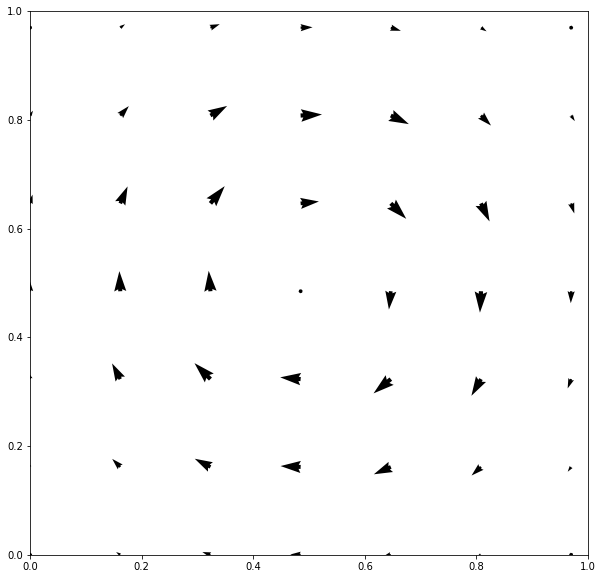

In [111]:
# determine centered
ds = 16

x_train=xx[::ds,::ds]
y_train=yy[::ds,::ds]
u_train= u[::ds,::ds]
v_train= v[::ds,::ds]
train_shape = x_train.shape

X_train = np.concatenate([x_train.reshape(-1,1), y_train.reshape(-1,1)], axis=1)
u_train = np.concatenate([u_train.reshape(-1,1), v_train.reshape(-1,1)], axis=1)

print(x_train.shape)
print(u_train.shape)

plt.figure(figsize=(10,10))
plt.quiver(X_train[:,0], X_train[:,1] , u_train[:,0], u_train[:,1], scale=30)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

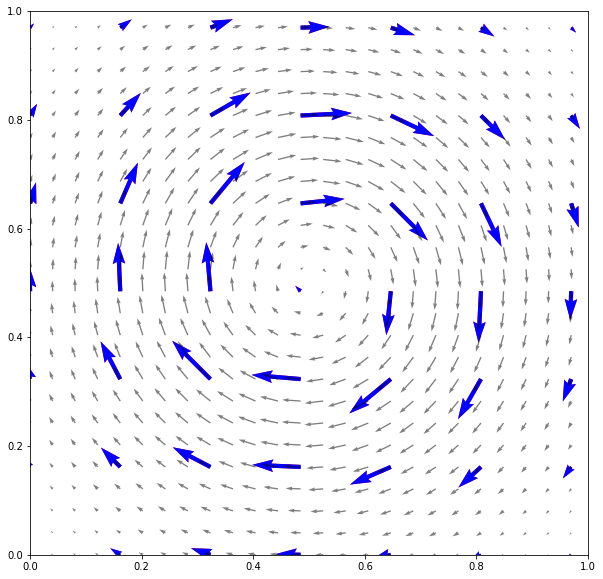

In [115]:
from turboflow.models.kernels import DivFreeRBFInterp
model = DivFreeRBFInterp(10)
model.fit(X_train, u_train)
u_pred_train = model(X_train)

plt.figure(figsize=(10,10))
plt.quiver(X_train[:,0], X_train[:,1], u_train[:,0], u_train[:,1], color='r')
plt.quiver(X_train[:,0], X_train[:,1], u_pred_train[:,0], u_pred_train[:,1], color='b')
ds = 4
plt.quiver(xx[::ds,::ds],yy[::ds,::ds],
            u[::ds,::ds], v[::ds,::ds],color='k',alpha=0.5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [124]:
ds = 2
x_test=xx[::ds,::ds]
y_test=yy[::ds,::ds]
u_test= u[::ds,::ds]
v_test= v[::ds,::ds]

# idx = 10
# idy = 10
# x_test=xx[idx,idy]
# y_test=yy[idx,idy]
# u_test= u[idx,idy]
# v_test= v[idx,idy]
test_shape = x_test.shape

X_test = np.concatenate([x_test.reshape(-1,1), y_test.reshape(-1,1)], axis=1)
u_test = np.concatenate([u_test.reshape(-1,1), v_test.reshape(-1,1)], axis=1)

print(X_test.shape)

u_pred_test = model(X_test)

print(u_pred_test.shape)

(2500, 2)
(2500, 2)


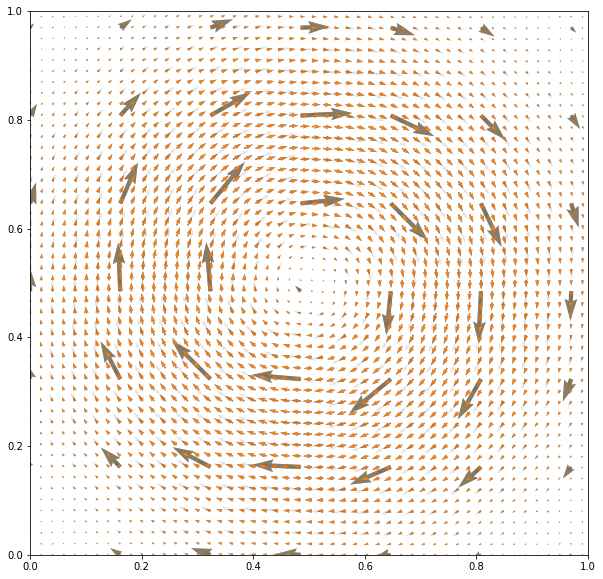

In [145]:
plt.figure(figsize=(10,10))
plt.quiver(X_train[:,0], X_train[:,1], u_train[:,0], u_train[:,1], color='C0')
plt.quiver(X_train[:,0], X_train[:,1], u_pred_train[:,0], u_pred_train[:,1], color='C1',alpha=0.5)
plt.quiver(X_test[:,0], X_test[:,1], u_test[:,0], u_test[:,1], color='C0')
plt.quiver(X_test[:,0], X_test[:,1], u_pred_test[:,0], u_pred_test[:,1], color='C1')
ds = 4
plt.quiver(xx[::ds,::ds],yy[::ds,::ds],
            u[::ds,::ds], v[::ds,::ds],color='k',alpha=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

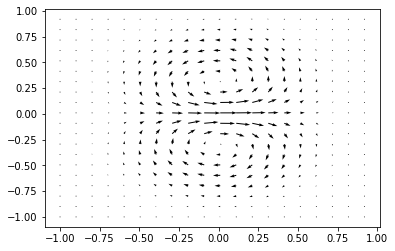

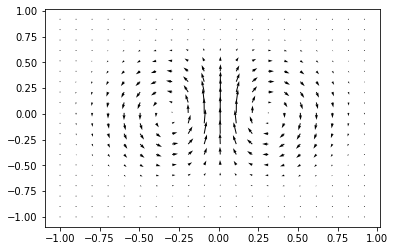

In [146]:
from turboflow.models.kernels import DivFreeRBFInterp
model = DivFreeRBFInterp(5)

x = np.linspace(-1,1,100)
xx, yy = np.meshgrid(x, x)

u1 = model.phi11(xx, yy)
u2 = model.phi21(xx, yy)

v1 = model.phi12(xx, yy)
v2 = model.phi22(xx, yy)

plt.quiver(xx[::5,::5], yy[::5,::5], u1[::5,::5], u2[::5,::5], scale=200)
plt.show()
plt.quiver(xx[::5,::5], yy[::5,::5], v1[::5,::5], v2[::5,::5], scale=200)
plt.show()

In [127]:
import pathlib
import numpy as np
from turboflow.datasets.turb2D import Turb2D
import matplotlib.pyplot as plt

In [128]:
data_dir = pathlib.Path('/','home','dicarlo_d','Documents','Datasets','2021-Turb2D')
turb2D = Turb2D(data_dir)
turb2D.setup()
turb2D.load_data(42)

{'t': 0.42,
 'xy': array([[[0.        , 0.        ],
         [0.        , 0.00392157],
         [0.        , 0.00784314],
         ...,
         [0.        , 0.99215686],
         [0.        , 0.99607843],
         [0.        , 1.        ]],
 
        [[0.00392157, 0.        ],
         [0.00392157, 0.00392157],
         [0.00392157, 0.00784314],
         ...,
         [0.00392157, 0.99215686],
         [0.00392157, 0.99607843],
         [0.00392157, 1.        ]],
 
        [[0.00784314, 0.        ],
         [0.00784314, 0.00392157],
         [0.00784314, 0.00784314],
         ...,
         [0.00784314, 0.99215686],
         [0.00784314, 0.99607843],
         [0.00784314, 1.        ]],
 
        ...,
 
        [[0.99215686, 0.        ],
         [0.99215686, 0.00392157],
         [0.99215686, 0.00784314],
         ...,
         [0.99215686, 0.99215686],
         [0.99215686, 0.99607843],
         [0.99215686, 1.        ]],
 
        [[0.99607843, 0.        ],
         [0.99607843, 0.

In [140]:
def generate_data(ds):
    xy = turb2D.xy
    uv = turb2D.uv
    
    xy = xy[::ds, ::ds, :].reshape(-1,2)
    uv = uv[::ds, ::ds, :].reshape(-1,2)
    
    return xy, uv

Xtrain, ytrain = generate_data(ds=16)
print(Xtrain.shape)
print(ytrain.shape)
L = int(Xtrain.shape[0]**.5)
Xtest, ytest = generate_data(ds=2)
print(Xtest.shape)
print(ytest.shape)
H = int(Xtest.shape[0]**.5)

(256, 2)
(256, 2)
(16384, 2)
(16384, 2)


In [141]:
from turboflow.models.kernels import DivFreeRBFInterp
model = DivFreeRBFInterp(100)
model.fit(Xtrain, ytrain)

In [142]:
ypred = model(Xtest)

In [143]:
ypred.shape

(16384, 2)

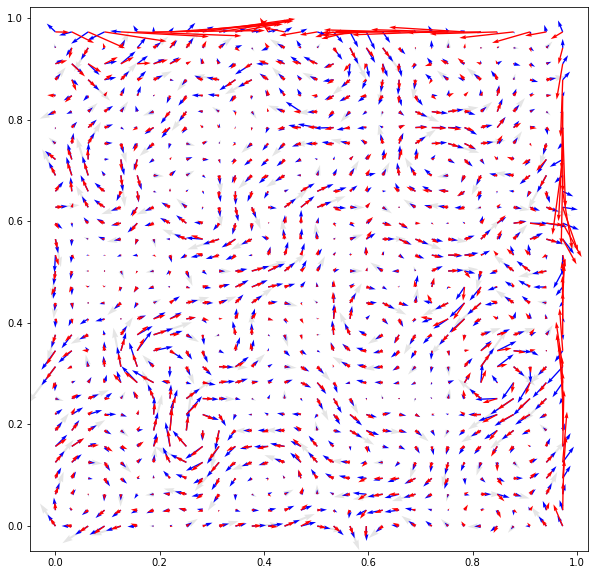

In [144]:
plt.figure(figsize=(10,10))
ds = 1
plt.quiver(Xtrain[:,0].reshape(L,L)[::ds,::ds],
           Xtrain[:,1].reshape(L,L)[::ds,::ds],
           ytrain[:,0].reshape(L,L)[::ds,::ds],
           ytrain[:,1].reshape(L,L)[::ds,::ds], alpha=0.1)
ds = 4
plt.quiver(Xtest[:,0].reshape(H,H)[::ds,::ds],
           Xtest[:,1].reshape(H,H)[::ds,::ds],
           ytest[:,0].reshape(H,H)[::ds,::ds],
           ytest[:,1].reshape(H,H)[::ds,::ds],
           color='b')
plt.quiver(Xtest[:,0].reshape(H,H)[::ds,::ds],
           Xtest[:,1].reshape(H,H)[::ds,::ds],
           ypred[:,0].reshape(H,H)[::ds,::ds],
           ypred[:,1].reshape(H,H)[::ds,::ds],color='r')